In [1]:
%load_ext autoreload
%autoreload 2

# Read the original projected data (face-on projection)

In [2]:
import sys
sys.path.insert(0, '../src')

In [3]:
from tigress_pickle_reader import TigressPickle
import glob
import os

In [4]:
basedir = "../data_ncr"
files = sorted(glob.glob(os.path.join(basedir, "prj_*.p")))
print(files)

['../data_ncr/prj_0200.p', '../data_ncr/prj_0210.p', '../data_ncr/prj_0220.p', '../data_ncr/prj_0230.p', '../data_ncr/prj_0240.p', '../data_ncr/prj_0250.p', '../data_ncr/prj_0260.p', '../data_ncr/prj_0270.p', '../data_ncr/prj_0280.p', '../data_ncr/prj_0290.p', '../data_ncr/prj_0300.p', '../data_ncr/prj_0310.p', '../data_ncr/prj_0320.p', '../data_ncr/prj_0330.p', '../data_ncr/prj_0340.p', '../data_ncr/prj_0350.p', '../data_ncr/prj_0360.p', '../data_ncr/prj_0370.p', '../data_ncr/prj_0380.p', '../data_ncr/prj_0390.p', '../data_ncr/prj_0400.p', '../data_ncr/prj_0410.p', '../data_ncr/prj_0420.p', '../data_ncr/prj_0430.p', '../data_ncr/prj_0440.p', '../data_ncr/prj_0450.p', '../data_ncr/prj_0460.p', '../data_ncr/prj_0470.p', '../data_ncr/prj_0480.p', '../data_ncr/prj_0490.p', '../data_ncr/prj_0500.p']


In [5]:
data = TigressPickle(files[-1], verbose=True)

In [6]:
data

TIGRESS-NCR pickle output: (256x256) data at time=499.6857
 domain info (length in pc): 
  xmin = -512.0  xmax = 512.0  ymin = -512.0  ymax = 512.0
  Lx = 1024.0  Ly = 1024.0  Nx = 256  Ny = 256
  dx = 4.0  dy = 4.0
 surface density (in Msun/pc^2):3.7052173614501953...3.9374170303344727

## Surface desnity map

In [7]:
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 200

Text(0, 0.5, 'y [pc]')

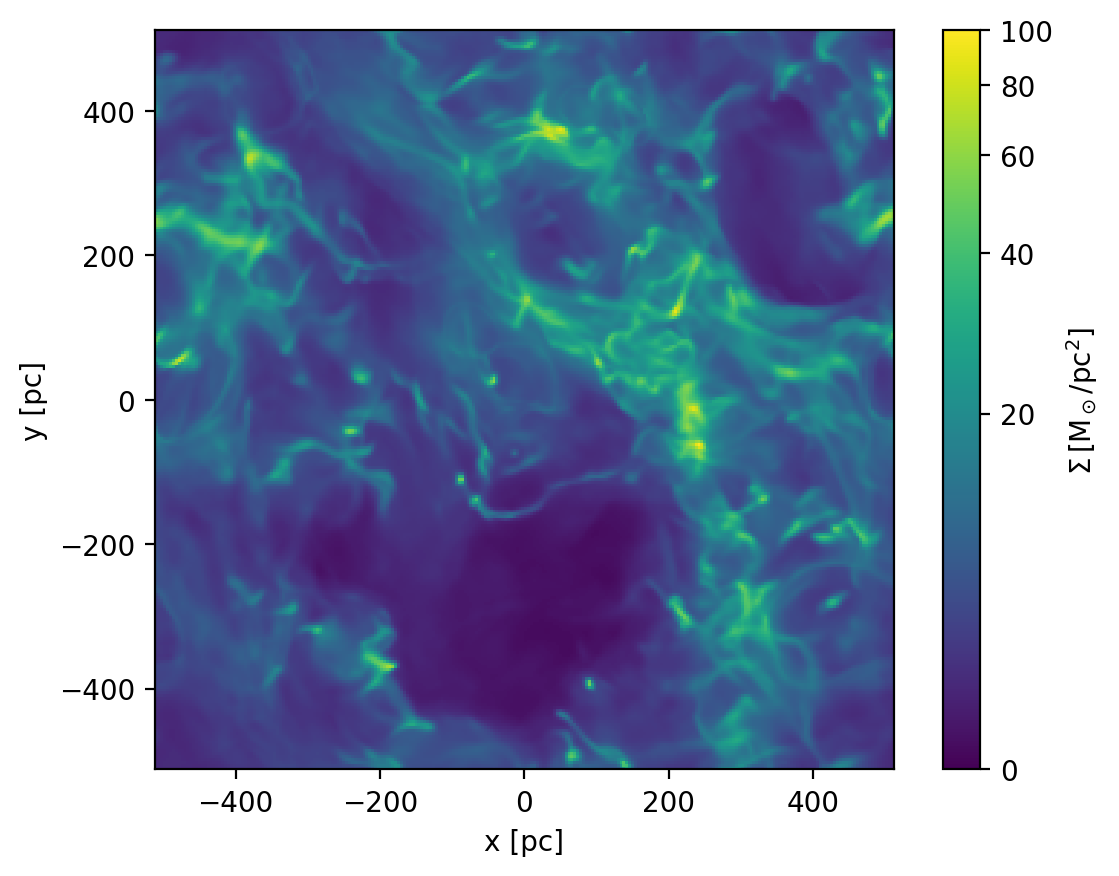

In [8]:
# set image stretch using asinh
from astropy.visualization import AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize

# Surface Density
norm = ImageNormalize(data.surf, vmin=0, vmax=100, stretch=AsinhStretch())
im = plt.pcolormesh(data.coords["x"], data.coords["y"], data.surf, norm=norm)
plt.gca().set_aspect("equal")
plt.colorbar(im, label=r"$\Sigma\,[{\rm M_\odot/pc^2}]$")
plt.xlabel("x [pc]")
plt.ylabel("y [pc]")

Text(0, 0.5, 'y [pc]')

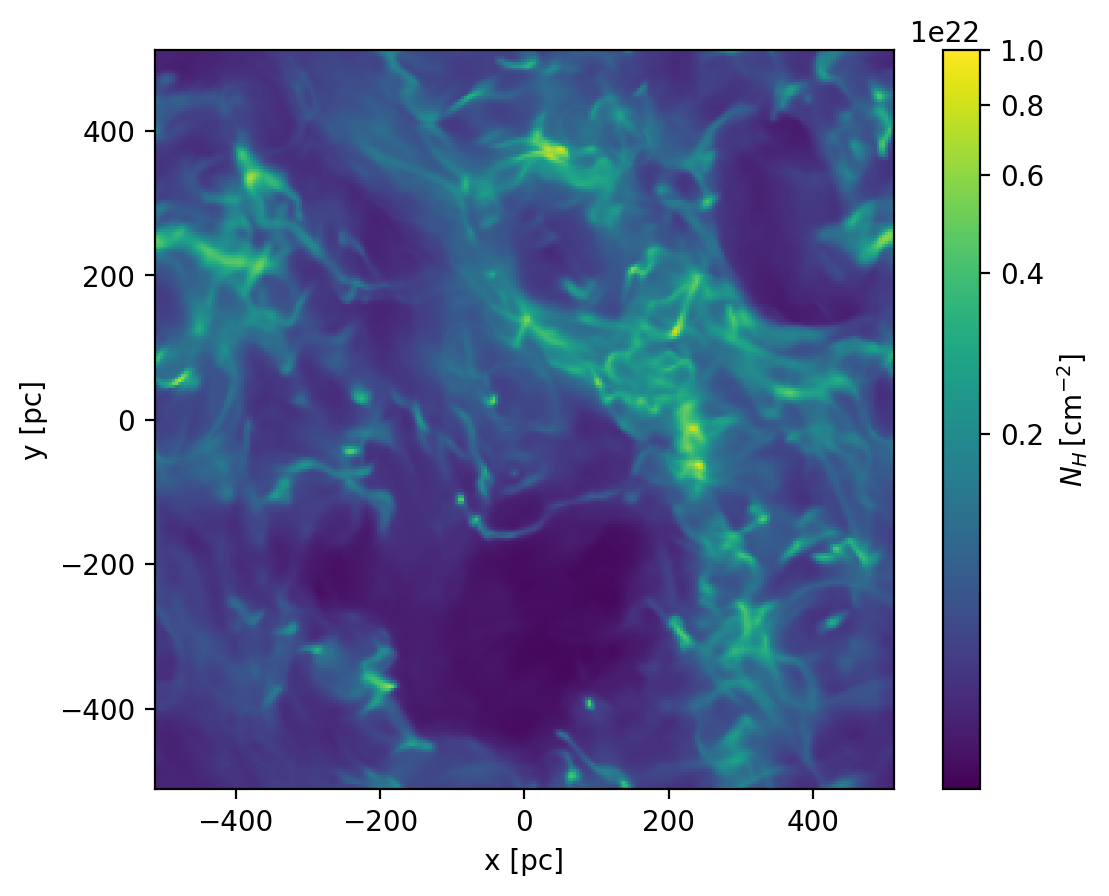

In [9]:
# set image stretch using asinh
from astropy.visualization import AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize

# Column Density
norm = ImageNormalize(data.NH, vmin=1.0e19, vmax=1.0e22, stretch=AsinhStretch())
im = plt.pcolormesh(data.coords["x"], data.coords["y"], data.NH, norm=norm)
plt.gca().set_aspect("equal")
plt.colorbar(im, label=r"$N_H\,[{\rm cm^{-2}}]$")
plt.xlabel("x [pc]")
plt.ylabel("y [pc]")

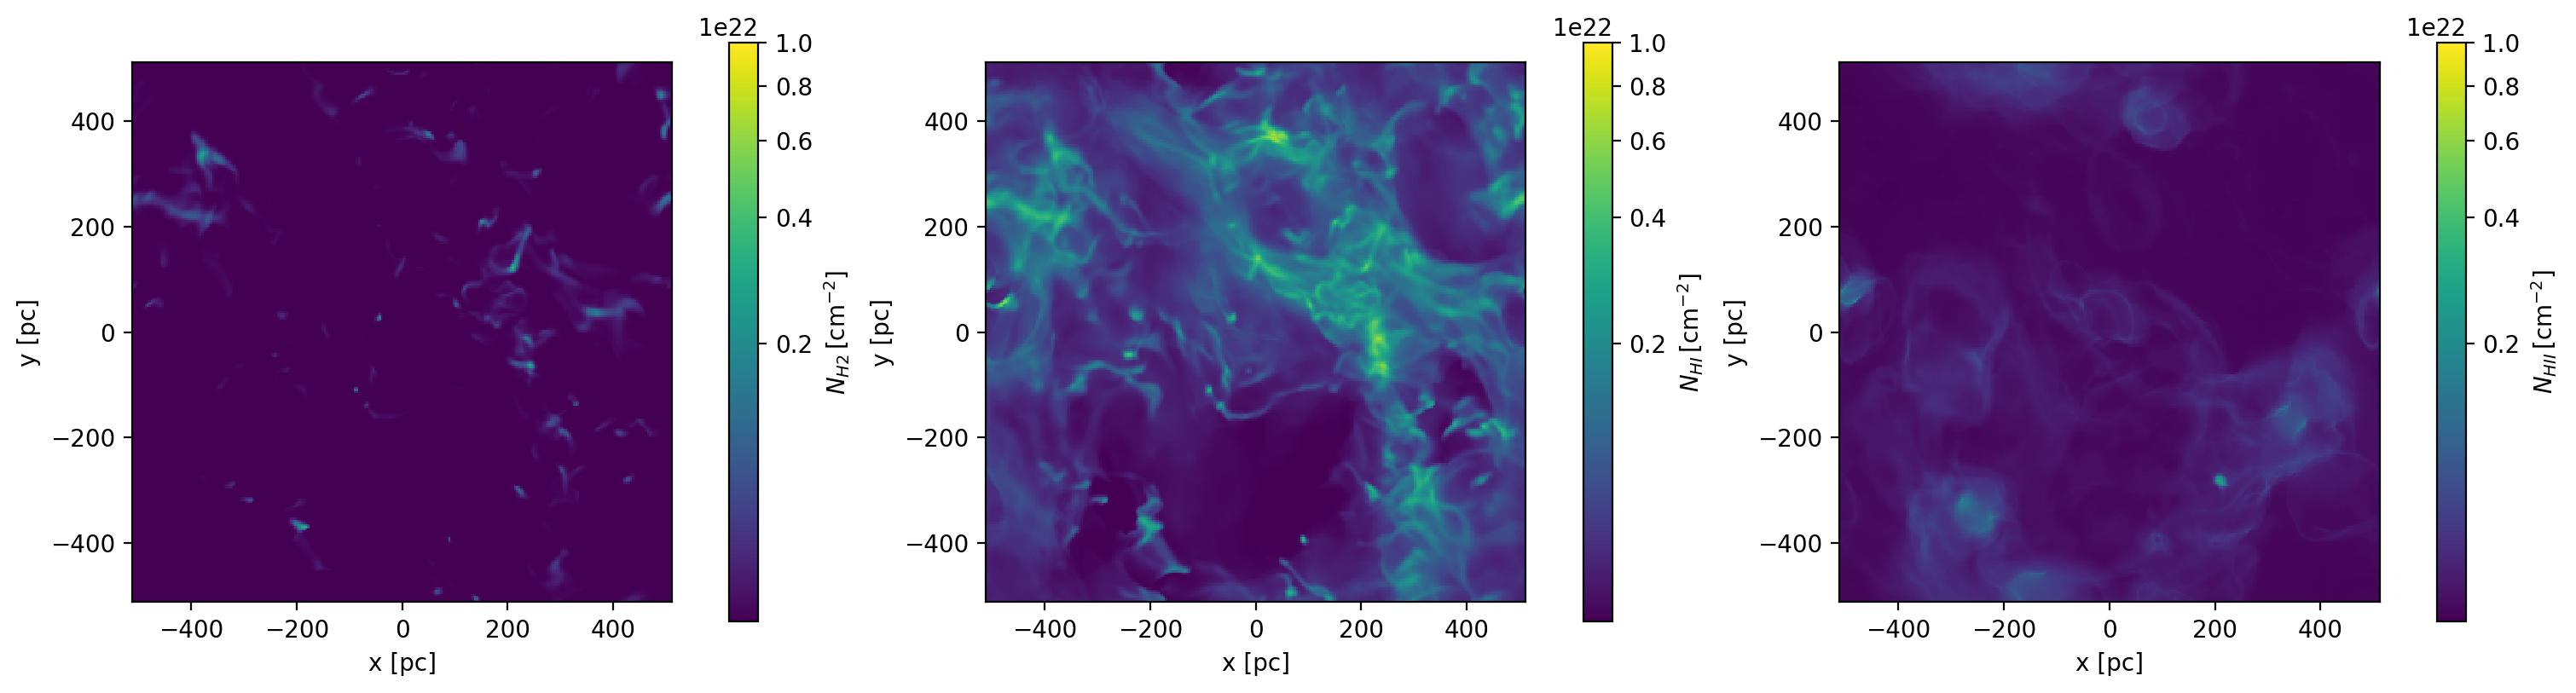

In [10]:
if data.model == "NCR":
    fig, axes = plt.subplots(1, 3, figsize=(15,4),constrained_layout=True)
    for field,ax in zip(["H2","HI","HII"],axes):
        plt.sca(ax)
        # Column Density
        colden = getattr(data,f"N_{field}")
        norm = ImageNormalize(colden, vmin=1.0e19, vmax=1.0e22, stretch=AsinhStretch())
        im = plt.pcolormesh(data.coords["x"], data.coords["y"], colden, norm=norm)
        plt.gca().set_aspect("equal")
        plt.colorbar(im, label=f"$N_{{{field}}}\\,[{{\\rm cm^{{-2}}}}]$")
        plt.xlabel("x [pc]")
        plt.ylabel("y [pc]")

# Domain Expansion using Shear-Periodic Boundary Conditions

## Motivation

If you want to calculate structure functions for regions touching the boundaries, you need information outside the boundaries, which in simulations you can get based on the boundary conditions applied. If it was simple periodic boundary conditions, expanding the domain should be much easier. But, our simulations utilze the shear-periodic boundary conditions, one has to be careful. If you need to expand the data into bigger domain, use the following example. Otherwise, just ignore this.

## Shear-Periodic Boundary Conditions

In a shearing-box, the background velocity is 
$$ v_{y,shear} = -q\Omega x $$
where the shear parameter $q\equiv -d\ln\Omega/d\ln R|_{R=R_{0}} = 1$ in our simulations. 

The shearing-periodic boundary conditions in $x$ at time $t$ then satisfy, e.g. for density,
$$ \rho(x\pm L_x,y,z) = \rho(x, \mod(y \mp q\Omega L_x t, L_y), z )$$
and all other quantities except $v_y$.

For $y$-velocity, the bacgkround velocity has to be added such that
$$ v_y(x\pm L_x,y,z) = v_y(x, \mod(y \mp q\Omega L_x t, L_y), z) \mp q\Omega L_x$$

In [11]:
from expand_domain import expand_xy

In [12]:
# the code assumes the data is given as xarray.DataArray
xr_data = data.to_xarray()

In [13]:
xr_data

<xarray.Dataset> Size: 1MB
Dimensions:    (y: 256, x: 256)
Coordinates:
  * y          (y) float64 2kB -510.0 -506.0 -502.0 -498.0 ... 502.0 506.0 510.0
  * x          (x) float64 2kB -510.0 -506.0 -502.0 -498.0 ... 502.0 506.0 510.0
Data variables:
    Sigma_gas  (y, x) float32 262kB 3.705 3.688 3.679 ... 4.149 4.026 3.937
    Sigma_HI   (y, x) float32 262kB 3.212 3.192 3.178 3.175 ... 3.605 3.485 3.4
    Sigma_H2   (y, x) float32 262kB 8.099e-07 8.62e-07 ... 5.156e-07 4.561e-07
    Sigma_HII  (y, x) float32 262kB 0.4929 0.497 0.5006 ... 0.5441 0.5415 0.5371

In [14]:
# NCR data has multiple fields, so we need to select one field, e.g., "Sigma_HI"
data_xy = expand_xy(xr_data["Sigma_HI"], data.domain, ysh=data.get_yshear())
data_xy = data_xy.sel(x=slice(data.domain["xmin"]*2, data.domain["xmax"]*2),
                      y=slice(data.domain["ymin"]*2, data.domain["ymax"]*2))

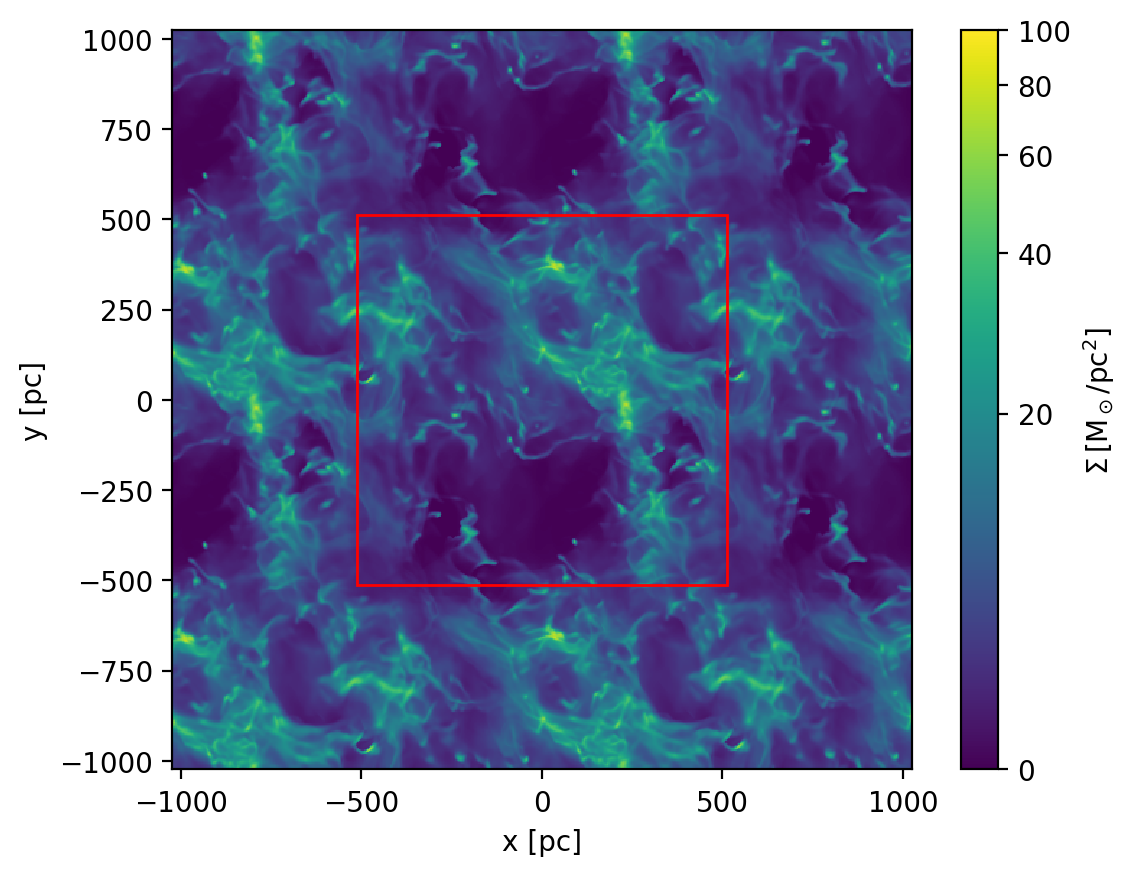

In [15]:
# set image stretch using asinh
from astropy.visualization import AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize

# Surface Density
norm = ImageNormalize(data_xy, vmin=0, vmax=100, stretch=AsinhStretch())
im = plt.pcolormesh(data_xy.x, data_xy.y, data_xy.data, norm=norm)
plt.gca().set_aspect("equal")
plt.colorbar(im, label=r"$\Sigma\,[{\rm M_\odot/pc^2}]$")
plt.xlabel("x [pc]")
plt.ylabel("y [pc]")

# add a box to show the original domain
import matplotlib.patches as patches

rect = patches.Rectangle(
    (data.domain["xmin"], data.domain["ymin"]),
    data.domain["Lx"],
    data.domain["Ly"],
    linewidth=1,
    edgecolor="r",
    facecolor="none",
)
plt.gca().add_patch(rect)